In [1]:
import os, warnings
import sys
import time
from datetime import datetime, timedelta, date

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2025-05-15 11:47:57.615515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 11:47:57.833432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747302477.957664   20862 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747302477.990534   20862 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 11:47:58.231892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0


In [2]:
# Input directory
INPUT_PATH = './DATA'
VARIABLES_TO_KEEP = ['swh', 'msl', 'ws', 'pp1d']

## Load data to pandas DataFrame

- load data separately due to different time dimension (legacy cds outputs data with "time" dimension from 1970-01-01 while recent cds version ouputs "valid_time" dimension from 1900-01-01)
- use netCDF4 library to load data
- use pandas to store data as DataFrame
- apply some preprocessing, such as removing rows with NaN values (year 2022 is incomplete for 1950-2022 file, and year 1956 is missing swh values for some reason…)

In [3]:
import netCDF4

# Load NetCDF file for 1940-1949
INPUT_FILES = [
    'ERA5_1940-1949_47N_2.5W_all_vars.nc',
    'ERA5_1950-2022_47N_2.5W_all_vars_v3.nc',
    'ERA5_2022_47N_2.5W_all_vars.nc',
    'ERA5_2023_47N_2.5W_all_vars.nc',
]

def load_netcdf_to_dataframe(input_file: str) -> pd.DataFrame:
    print(f"Processing {input_file}")
    f = netCDF4.Dataset(input_file)
    
    # Extract variables as lists
    series = []
    for v in VARIABLES_TO_KEEP:
        series.append(f[v][:].flatten())
    
    # Reshape array to get rows of values for each timestep
    np_array = np.array(series)
    np_array = np.swapaxes(np_array, 0, 1)
    
    # Get time variable
    try:
        times = f.variables['time']
    except:
        times = f.variables['valid_time']
    # Convert time to Python datetime
    jd = netCDF4.num2date(times[:],units=times.units, calendar=times.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    # Populate DataFrame with data
    df = pd.DataFrame(np_array, index=jd, columns=VARIABLES_TO_KEEP)
    df = df.reset_index()
    # Rename columns for concatenation
    df.rename(columns={"index": "date"}, inplace=True)
    return df

input_dataframe = pd.DataFrame()
for nc_file in INPUT_FILES:
    df = load_netcdf_to_dataframe(os.path.join(INPUT_PATH, nc_file))
    # Remove 2022 year from 1950-2022 file as it contains NaN values
    if nc_file == 'ERA5_1950-2022_47N_2.5W_all_vars_v3.nc':
        df.drop(df[df['date'].dt.year == 2022].index, inplace=True)
    input_dataframe = pd.concat([df[['date', *VARIABLES_TO_KEEP]], input_dataframe], axis=0)

# Sort by date and remove any row with NaN value
input_dataframe = input_dataframe.sort_values(by='date').dropna()
print(f"Output dataframe has {len(input_dataframe)} hourly values")

Processing ./DATA/ERA5_1940-1949_47N_2.5W_all_vars.nc
Processing ./DATA/ERA5_1950-2022_47N_2.5W_all_vars_v3.nc
Processing ./DATA/ERA5_2022_47N_2.5W_all_vars.nc
Processing ./DATA/ERA5_2023_47N_2.5W_all_vars.nc
Output dataframe has 727560 hourly values


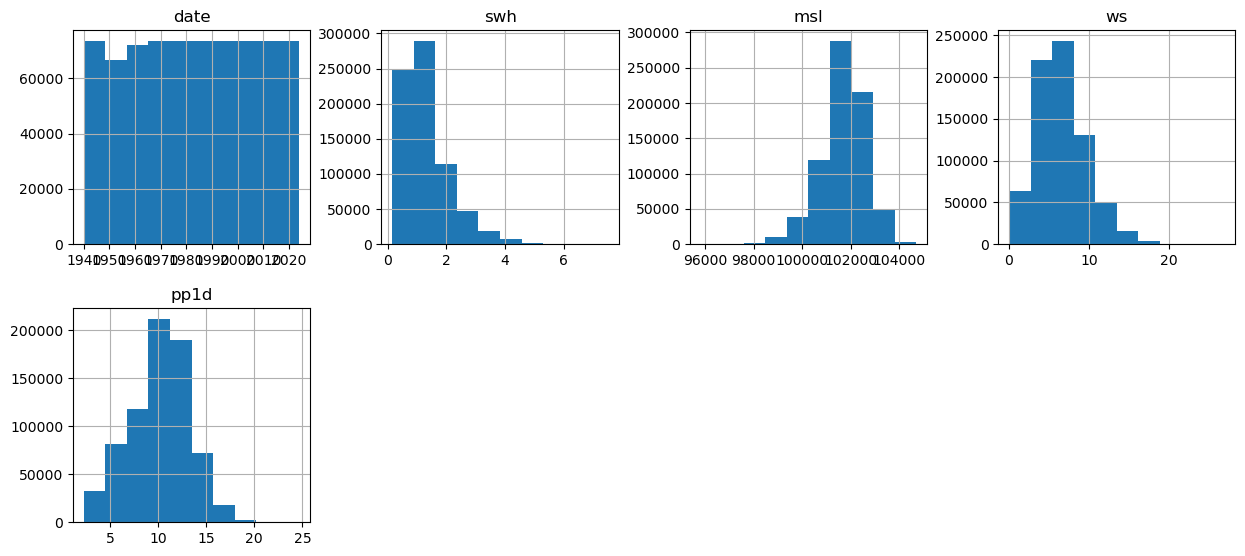

In [4]:
input_dataframe.hist(layout=(3,4), figsize=(15,10))
plt.show()

### Extract outliers

- Define outliers based on quantile for specific wind waves height
- Threshold is set as 0.95

In [5]:
def extract_quantile(dataframe, quantile=0.99):
    outliers_dataframe = dataframe.copy(deep=True)
    # Compute quantile for swh
    Q = quantile
    threshold = round(outliers_dataframe['swh'].quantile(Q), 3)
    print("Quantile threshold set as {} returns {}".format(Q, str(threshold)))
    outliers_dataframe['swh'] = outliers_dataframe['swh'].where(outliers_dataframe['swh'].ge(threshold))
    # Remove rows with NaN values in swh column
    outliers_dataframe = outliers_dataframe.dropna()
    print("{} hours have a swh mean value greater than {}".format(len(outliers_dataframe.index), str(threshold)))
    return outliers_dataframe, threshold

outliers_dataframe, SWH_THRESHOLD = extract_quantile(input_dataframe, 0.95)

print(f"Output dataframe has {len(outliers_dataframe)} hourly values")

Quantile threshold set as 0.95 returns 2.929
36366 hours have a swh mean value greater than 2.929
Output dataframe has 36366 hourly values


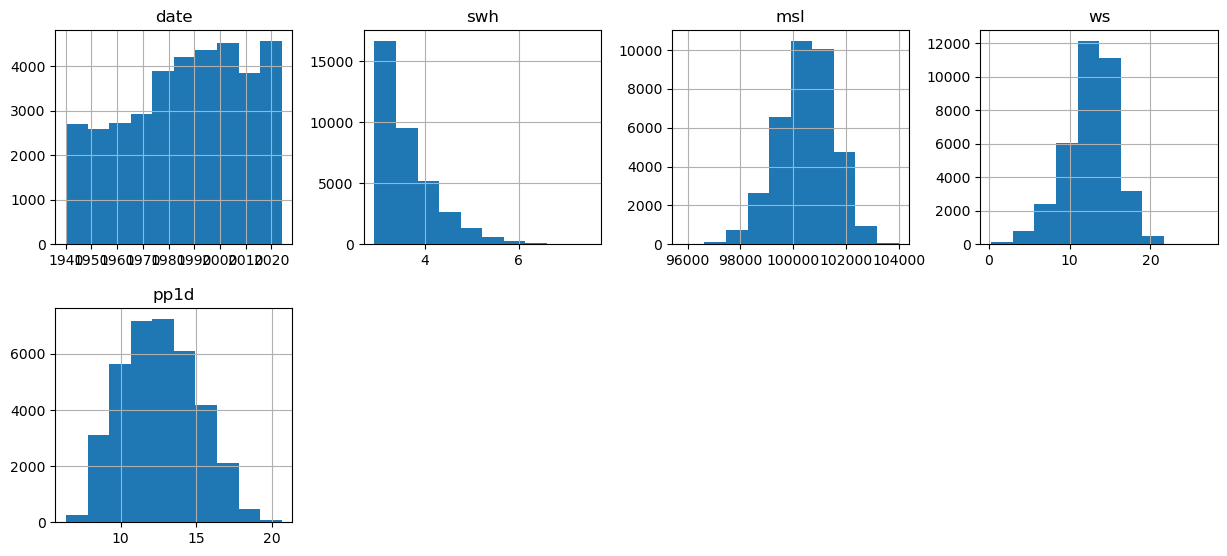

In [6]:
outliers_dataframe.hist(layout=(3,4), figsize=(15,10))
plt.show()

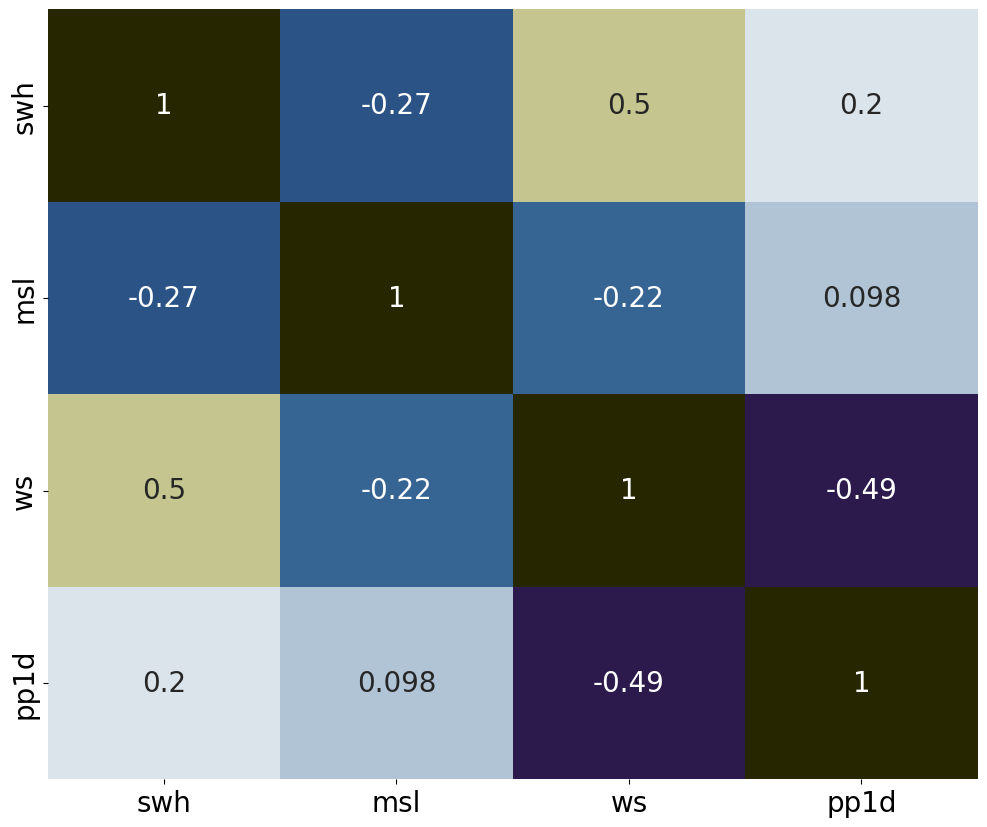

In [7]:
from cmcrameri import cm
import seaborn as sns

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))
corr = outliers_dataframe.corr(numeric_only=True)
# Generate a mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
h = sns.heatmap(corr, annot=True, cmap=cm.broc, cbar=False)
h.set_xticklabels(h.get_xmajorticklabels(), size = 20)
h.set_yticklabels(h.get_ymajorticklabels(), size = 20)
f.savefig("FIGS/Pearson_correlation_matrix.png", bbox_inches='tight', dpi=300)

## Plotting extreme hourly values per month
- see if they only occurs in winter season or all along the year

<Axes: >

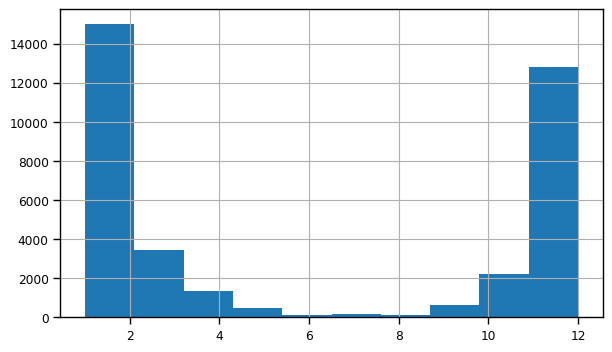

In [8]:
month_frequency = outliers_dataframe['date'].dt.month
month_frequency.hist(figsize=(7,4))

### Snippet for timeseries inspection

In [9]:
start_time = "1999-12-26"
end_time = "1999-12-28"
temp_data = input_dataframe.reset_index()
selection = temp_data[(temp_data["date"] >= start_time) & (temp_data["date"] <= end_time)]
print(max(selection['swh']))

6.6154561042785645


## Normalize data to [0,1] using MinMaxScaler

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = input_dataframe.copy(deep=True)
scaled_df = scaled_df[['date', *VARIABLES_TO_KEEP]]
scaled_df[VARIABLES_TO_KEEP] = scaler.fit_transform(scaled_df[VARIABLES_TO_KEEP])

print(scaled_df.head())

                 date       swh       msl        ws      pp1d
0 1940-01-01 00:00:00  0.180163  0.649288  0.307151  0.602304
1 1940-01-01 01:00:00  0.182821  0.647956  0.310196  0.601517
2 1940-01-01 02:00:00  0.185607  0.648337  0.309045  0.600144
3 1940-01-01 03:00:00  0.188956  0.647888  0.314788  0.598259
4 1940-01-01 04:00:00  0.193007  0.649641  0.320571  0.595932


## Apply Peak Over Threshold method (Extreme Value Theory) with independence criteria

1. exceedances over defined threshold are extracted
2. an arbitrary threshold of 24 hours is used for declustering and extracting independant events
3. diagnostic plot is provided as well as return period estimation of extreme swh values

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='date', ylabel='swh'>)

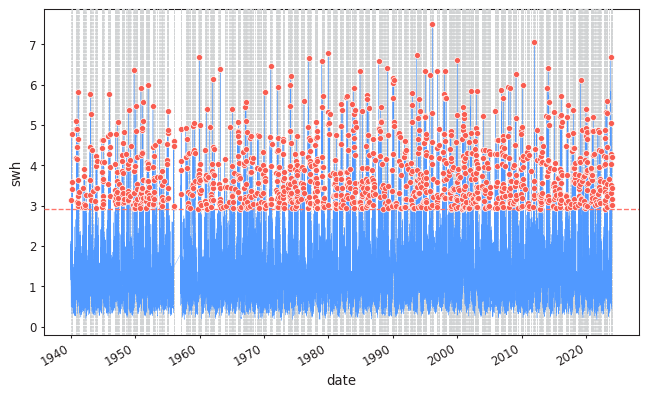

In [12]:
from pyextremes import EVA

series = input_dataframe[['date', 'swh']].set_index('date')['swh']
model = EVA(series)
model.get_extremes("POT", threshold=SWH_THRESHOLD, r="24h", extremes_type="high")
model.plot_extremes(show_clusters=True)

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='swh'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='swh', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

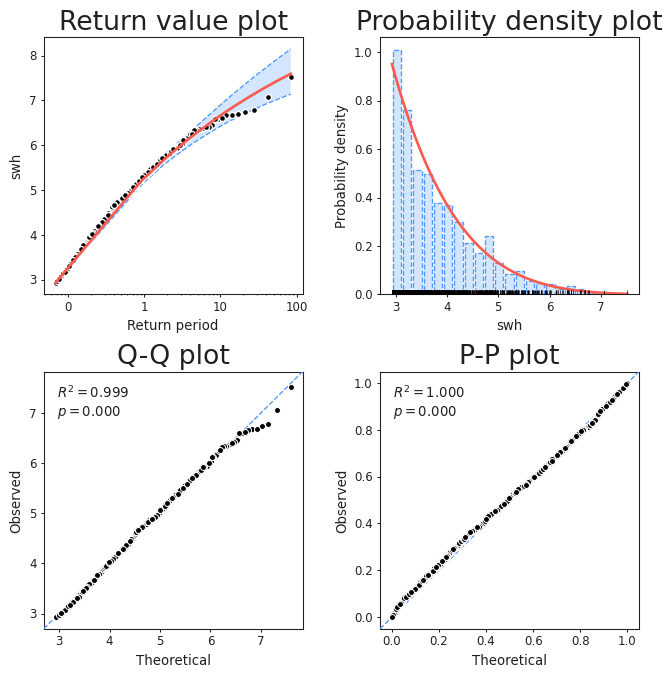

In [13]:
model.fit_model()
model.plot_diagnostic(alpha=0.95)

In [14]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value  lower ci  upper ci
return period                                  
1.0                5.270345  5.165162  5.362332
2.0                5.739291  5.601162  5.857043
5.0                6.290872  6.096758  6.459145
10.0               6.661900  6.422100  6.897563
25.0               7.098309  6.774929  7.435208
50.0               7.391865  7.007304  7.825363
100.0              7.657254  7.211543  8.190499
250.0              7.969409  7.431207  8.640894
500.0              8.179384  7.572263  8.949743
1000.0             8.369212  7.693343  9.244517


### Create unequal windows based on minimas

- start from exceedances extracted at previous step using PoT method
- construct windows by looking at previous and next local minimas

In [16]:
from scipy.signal import argrelmax, argrelmin, find_peaks

def find_minimas_below_threshold(dataframe: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    Finds local minimas using scipy find_peaks method
    Filter them to get those below given threshold only
    """
    minimas_indices = find_peaks(-1 * dataframe.values)[0]
    minimas = [value if (index in minimas_indices and value < threshold) else 0 for index, value in enumerate(dataframe.values)]
    return pd.Series(minimas)

def create_minimas_windows(dataframe: pd.DataFrame, outliers: pd.DataFrame, swh_threshold: float) -> list:
    # For each outlier, find previous and next local minimas
    window_list = []
    
    minimas_value_list = find_minimas_below_threshold(dataframe['swh'], swh_threshold)
    minimas_index_list = minimas_value_list.to_numpy().nonzero()
    minimas = dataframe.iloc[minimas_index_list[0]]
    
    for date in outliers.index:
        try:
            low_boundary = minimas[minimas.date < date].iloc[-1].date
        except:
            # Could not find date before the one concerned. Just taking the first value
            low_boundary = minimas.iloc[0].date
        try:
            high_boundary = minimas[minimas.date > date].iloc[0].date
        except:
            # Could not find date after the one concerned. Just taking the last value
            high_boundary = dataframe.iloc[-1].date
        
        current_window = [low_boundary, high_boundary]
        if current_window in window_list:
            pass
        else:
            window_list.append(current_window)
    print("{} generated windows".format(len(window_list)))
    return window_list


minima_windows = create_minimas_windows(input_dataframe, model.extremes, SWH_THRESHOLD)

1237 generated windows


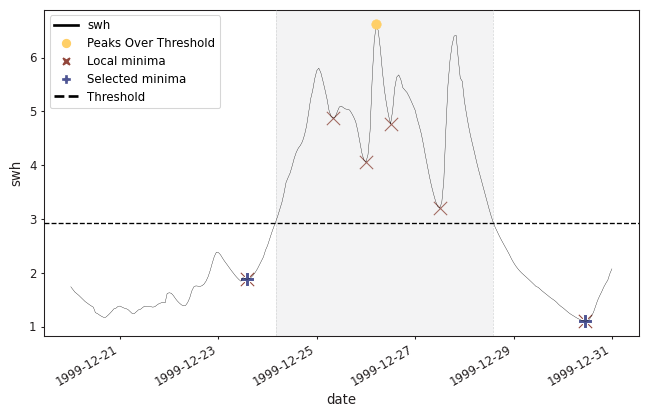

In [17]:
from pyextremes.plotting import plot_extremes
from matplotlib.lines import Line2D
from cmcrameri import cm
import seaborn as sns

COLORS = cm.managua(np.linspace(0, 1, 4))

fig, ax = plot_extremes(
    ts=series.loc[(series.index >= "1999-12-20") & (series.index <= "1999-12-31")],
    extremes=model.extremes.loc[(model.extremes.index >= "1999-12-20") & (model.extremes.index <= "1999-12-31")],
    extremes_method="POT",
    extremes_type="high",
    threshold=SWH_THRESHOLD,
    r="24h",
)
# Update colors to comply with NHESS color schemes
ax.get_lines()[0].set_color("black") # swh main line
ax.get_lines()[3].set_color("black") # threshold dashed line
# scatter extreme points
collections = ax.collections
collections[0].set_facecolor(COLORS[0])
collections[0].set_edgecolor(COLORS[0])
collections[0].set_sizes([50])

# Plot local minima
series_copy = series.reset_index()
series_copy = series_copy.loc[(series_copy['date'] >= "1999-12-23 12:00:00") & (series_copy['date'] <= "1999-12-31 12:00:00")]
series_copy['th'] = SWH_THRESHOLD

minimas_th_value_list = find_minimas_below_threshold(series_copy['swh'], SWH_THRESHOLD)
minimas_th_index_list = minimas_th_value_list.to_numpy().nonzero()
minimas_th = series_copy.iloc[minimas_th_index_list[0]]

minimas_indices = find_peaks(-1 * series_copy['swh'].values)[0]
minimas_series = pd.Series([value if (index in minimas_indices) else 0 for index, value in enumerate(series_copy['swh'].values)])
minimas_index_list = minimas_series.to_numpy().nonzero()
minimas = series_copy.iloc[minimas_index_list[0]]

sns.scatterplot(data=minimas, x="date", y="swh", color=COLORS[1], ax=ax, marker="x", s=100)
sns.scatterplot(data=minimas_th, x="date", y="swh", color=COLORS[2], ax=ax, marker="P", s=100)

# Add custom legend items
legend_elements = [Line2D([0], [0], color='k', lw=2, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor=COLORS[0], markersize=8),
                   Line2D([0], [0], marker='X', color='w', label='Scatter',
                          markerfacecolor=COLORS[1], markersize=8),
                   Line2D([0], [0], marker='P', color='w', label='Scatter',
                          markerfacecolor=COLORS[2], markersize=8),
                   Line2D([0], [0], color='k', linestyle="--", lw=2, label='Line'),]
ax.legend(legend_elements, ['swh', 'Peaks Over Threshold', 'Local minima', 'Selected minima', 'Threshold'])
plt.savefig("FIGS/Timeseries_creation_example.pdf", dpi=300, bbox_inches='tight')

### Compute timeseries from windows

Once windows are defined, recreate timeseries from original data

In [19]:
def findHigherDivider(N, K):
    """
    Function to find the largest number smaller 
    than or equal to N that is divisible by k
    """
      
    rem = N % K
    if(rem == 0):
        return N
    else:
        return N - rem
        
def compute_unequal_timeseries(dataframe, merged_windows):
    timeseries = []
    window_length_list = [(window[1] - window[0]).days for window in merged_windows]
    max_window_length = np.max(window_length_list)
    min_window_length = np.min(window_length_list)
    
    print("Max number of days for a window : {}".format(max_window_length))
    print("Min number of days for a window : {}".format(min_window_length))
    
    for window in merged_windows:
        rows = dataframe[(dataframe['date'] >= window[0]) & (dataframe['date'] <= window[1])]
        timeseries.append(rows.drop(columns=['date']).to_numpy())
    print(f"Number of timeseries : {len(timeseries)}")
    # Time dimension should be divisible by 8 (i.e. dimension reduction factor in encoder)
    max_length = max([len(t) for t in timeseries])
    if max_length%8 > 0:
        # Find highest value divisible by 8
        max_length = findHigherDivider(max_length, 8)
        # Cut all series that exceeds this dimension
        timeseries = [ts[:max_length] if len(ts) > max_length else ts for ts in timeseries]
    return timeseries

unequal_ts = compute_unequal_timeseries(scaled_df, minima_windows)

# If timeseries have different lengths, numpy can't convert to array
# Pad it with zeros to get something like [[0 0 0], [0 0 0], [xi xj xk]]
max_length = max([len(t) for t in unequal_ts])
unequal_padded_ts = [np.pad(t, ((max_length - len(t), 0), (0, 0))) for t in unequal_ts]

Max number of days for a window : 9
Min number of days for a window : 0
Number of timeseries : 1237


## Plot distribution of timeseries length

Longest timeseries is 216 hours long. Its index is 786
Shortest timeseries is 8 hours long. Its index is 1030
Median duration is 48.0 hours long.


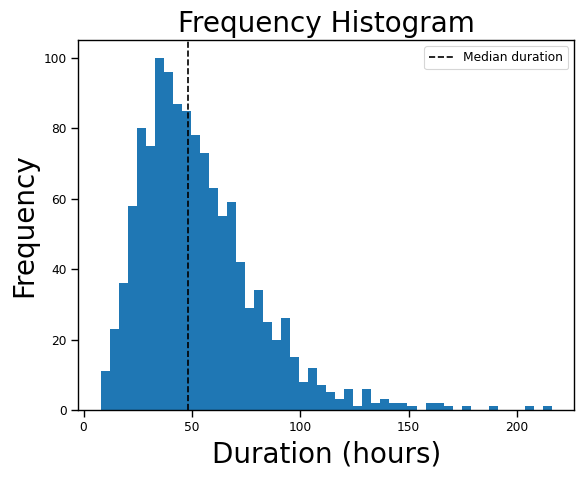

In [20]:
ts_length = [len(ts) for ts in unequal_ts]
first_max = next(filter(lambda ts: len(ts) >= max_length, unequal_ts), None)
max_idx = next((i for i, arr in enumerate(unequal_ts) if np.array_equal(arr, first_max)), None)
first_min = next(filter(lambda ts: len(ts) == np.min(ts_length), unequal_ts), None)
min_idx = next((i for i, arr in enumerate(unequal_ts) if np.array_equal(arr, first_min)), None)
print(f"Longest timeseries is {np.max(ts_length)} hours long. Its index is {max_idx}")
print(f"Shortest timeseries is {np.min(ts_length)} hours long. Its index is {min_idx}")
print(f"Median duration is {np.median(ts_length)} hours long.")
plt.hist(ts_length, bins=50)
plt.axvline(np.median(ts_length), color="black", ls="--", label="Median duration")
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Duration (hours)')
plt.legend()

## Timeseries samples

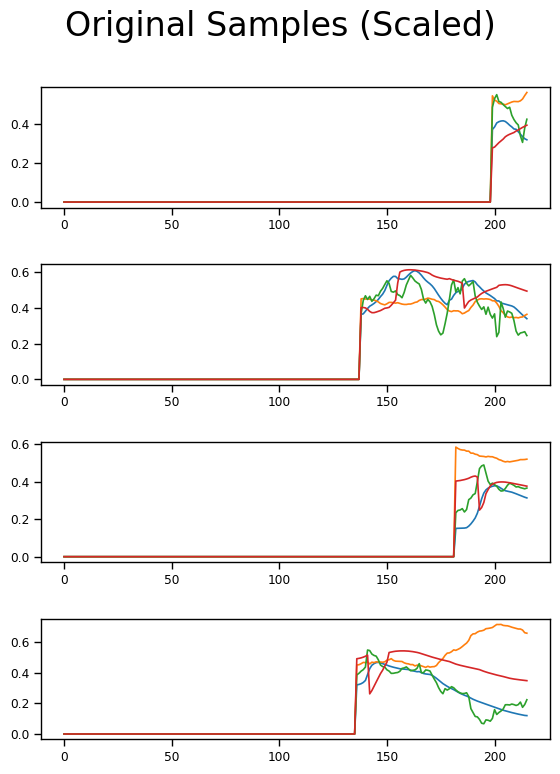

In [22]:
import random

# Rename python variables for sake of simplicity

dataframe = scaled_df
windows = minima_windows
timeseries = unequal_padded_ts

def plot_samples(samples, n):    
    fig, axs = plt.subplots(n, 1, figsize=(6,8))
    i = 0
    for _ in range(n):
        rnd_idx = np.random.choice(len(samples))
        s = samples[rnd_idx]
        axs[i].plot(s)    
        i += 1

    fig.suptitle("Original Samples (Scaled)")
    fig.tight_layout()
    plt.show()

plot_samples(timeseries, 4)

0 #ffcf67
1 #572949
2 #81e7ff


/home/hervy-b/miniconda3/envs/timeseries-clustering/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hervy-b/miniconda3/envs/timeseries-clustering/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hervy-b/miniconda3/envs/timeseries-clustering/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hervy-b/miniconda3/envs/timeseries-clustering/lib/python3.11/site-packages/seaborn

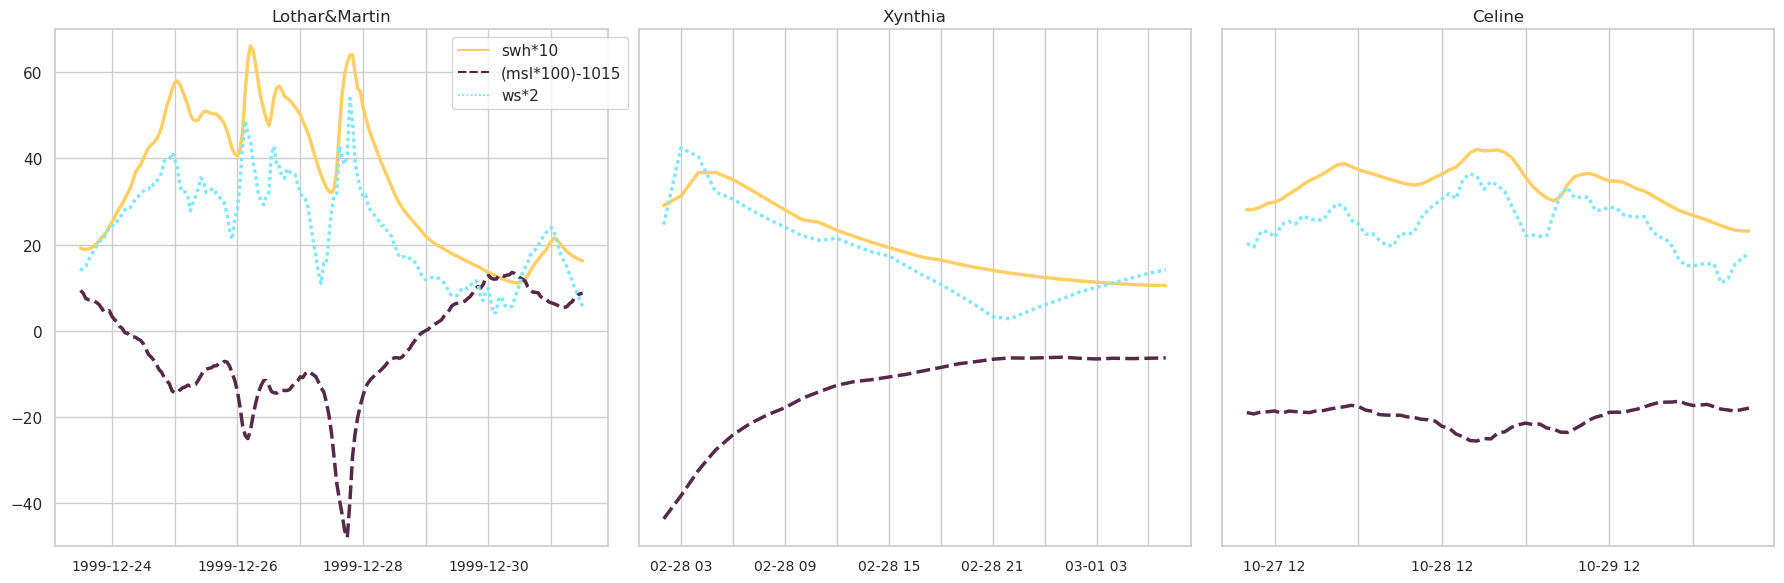

In [23]:
from cmcrameri import cm
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

modified_df = input_dataframe.copy(deep=True)

# Compute values to fit layout with specific scale per variable
modified_df['(msl*100)-1015'] = modified_df['msl']/100 - 1015
modified_df['swh*10'] = modified_df['swh']*10
modified_df['ws*2'] = modified_df['ws']*2

data = {
    "Lothar&Martin": modified_df.loc[(input_dataframe['date'] >= "1999-12-23 12:00:00") & (modified_df['date'] <= "1999-12-31 12:00:00")],
    "Xynthia": modified_df.loc[(input_dataframe['date'] >= "2010-02-28 02:00:00") & (modified_df['date'] <= "2010-03-01 07:00:00")],
    "Celine": modified_df.loc[(input_dataframe['date'] >= "2023-10-27 08:00:00") & (modified_df['date'] <= "2023-10-30 08:00:00")]
}

# Create ListedColorMap with hexadecimal values from cmcrameri to be compatible with seaborn
COLORS = [mcolors.to_hex(cm.managua(i)) for i in np.linspace(0, 1, 3)]
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loop over subplots
for i, ax in enumerate(axs):

    # Get data
    storm_name = list(data.keys())[i]
    plot_data = data[storm_name]
    
    # Plot creation
    print(i, COLORS[i])
    sns.lineplot(data=plot_data[['date', 'swh*10', '(msl*100)-1015', 'ws*2']].set_index('date'), ax=ax, palette=COLORS, linewidth=2.5)
    
    # Add title and legend
    ax.set_title(f'{storm_name}')
    if i > 0:
        ax.get_legend().set_visible(False)
        ax.get_yaxis().set_visible(False)
    else:
        ax.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
    ax.set_ylim(-50, 70)
    ax.tick_params(axis='x', labelsize=10)
    ax.set_xlabel("")

    for j, tick in enumerate(ax.get_xticklabels()):
        if j % 2 != 0:
            tick.set_visible(False)

# Display plot
plt.tight_layout()
plt.show()
# Save figure
fig.savefig("FIGS/Reference_storm_plot.pdf", dpi=300)

## Train and test sets creation

In [24]:
# read data 
perc_of_train_used = 20     # 5, 10, 20, 100    
valid_perc = 0.1
full_train_data = np.array(timeseries)
N, T, FEAT_DIM = full_train_data.shape
print('Data shape:', N, T)
print(f"WARNING, time dimension {T} should be divisible by 8: {T%8 == 0}")

Data shape: 1237 216
WARNING, time dimension 216 should be divisible by 8: True


In [25]:
# further split the training data into train and validation set
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train

train_data = full_train_data[:N_train]
valid_data = full_train_data[N_train:]

print("train/valid shapes: ", len(train_data), len(valid_data))
SEQ_LEN = T

train/valid shapes:  1113 124


## Export data to be reused

In [28]:
OUTPUT_DIR = "./DATA/PROCESSED"
COORDINATES = [47, -2.5]
OUTPUT_FILE_PREPEND = f"POT_{str(COORDINATES[0])}N_{str(abs(COORDINATES[1]))}W_"
OUTPUT_FILE_ADDITIONAL_PREPEND = ""

dataframe = scaled_df
windows = minima_windows
timeseries = unequal_padded_ts
# Compute timeseries on raw data in addition to normalized data
unequal_raw_ts = compute_unequal_timeseries(input_dataframe[['date', *VARIABLES_TO_KEEP]], windows)

np.savez(os.path.join(OUTPUT_DIR, OUTPUT_FILE_PREPEND + OUTPUT_FILE_ADDITIONAL_PREPEND + "np_train_data.npz"), train_data=full_train_data, windows=windows, raw_timeseries=np.array(unequal_raw_ts, dtype=object), timeseries=np.array(unequal_ts, dtype=object), padded_timeseries=timeseries)
input_dataframe.to_pickle(os.path.join(OUTPUT_DIR, OUTPUT_FILE_PREPEND + OUTPUT_FILE_ADDITIONAL_PREPEND + "full_dataframe.pkl"))
model.extremes.to_pickle(os.path.join(OUTPUT_DIR, OUTPUT_FILE_PREPEND + OUTPUT_FILE_ADDITIONAL_PREPEND + "95q_outliers_df.pkl"))

Max number of days for a window : 9
Min number of days for a window : 0
Number of timeseries : 1237
